In [13]:
import os
import glob
import cv2
import pandas as pd
import numpy as np
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [44]:
img_root = "/home/ubuntu/workspace/Airbus_ship/dataset/train_v2"

Create filelists which are successfully downloaded

In [45]:
train_df = pd.read_csv("/home/ubuntu/workspace/Airbus_ship/dataset/train_ship_segmentations_v2.csv", index_col=0)
len(train_df)
train_df.head()

,EncodedPixels
ImageId,
00003e153.jpg,NaN
0001124c7.jpg,NaN
000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [46]:
img_list = glob.glob("/home/ubuntu/workspace/Airbus_ship/dataset/train_v2/*")
img_list = [os.path.basename(path) for path in img_list]
len(img_list)

90548

In [47]:
train_df = train_df.loc[img_list, :]
train_df.head()

,EncodedPixels
ImageId,
0ded2b75a.jpg,129991 4 130753 10 131514 17 132275 24 133037 ...
0ded2b75a.jpg,135383 1 136150 3 136916 5 137683 7 138450 9 1...
0ded2b75a.jpg,154538 3 155300 9 156063 14 156825 20 157590 2...
0ded2b75a.jpg,256704 1 257471 2 258237 4 259004 5 259773 5 2...
225efe23e.jpg,NaN


In [48]:
train_df.to_csv("/home/ubuntu/workspace/Airbus_ship/dataset/train.csv")

In [49]:
train_extracted_df = train_df.dropna()
train_extracted_df.to_csv("/home/ubuntu/workspace/Airbus_ship/dataset/train_extracted.csv")

Visualize sample image

In [50]:
train_df = pd.read_csv("/home/ubuntu/workspace/Airbus_ship/dataset/train.csv")

In [51]:
train_df.head()

,ImageId,EncodedPixels
0,0ded2b75a.jpg,129991 4 130753 10 131514 17 132275 24 133037 ...
1,0ded2b75a.jpg,135383 1 136150 3 136916 5 137683 7 138450 9 1...
2,0ded2b75a.jpg,154538 3 155300 9 156063 14 156825 20 157590 2...
3,0ded2b75a.jpg,256704 1 257471 2 258237 4 259004 5 259773 5 2...
4,225efe23e.jpg,NaN


In [52]:
img_name = train_df.iloc[0]["ImageId"]
img1 = cv2.imread(os.path.join(img_root, img_name))
label1 = train_df[train_df["ImageId"] == img_name]["EncodedPixels"].tolist()

rle decoder

In [53]:
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns 
        - numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

In [54]:
all_masks = np.zeros((768, 768))
bboxes = []
for l in label1:
    mask = rle_decode(l)
    props = regionprops(mask)
    for prop in props:
        bbox = [prop.bbox[1], prop.bbox[0], prop.bbox[3], prop.bbox[2]]
        bboxes.append(bbox)
    all_masks += mask


[169, 168, 355, 229]
[176, 204, 195, 220]
[201, 149, 217, 174]
[334, 187, 346, 193]


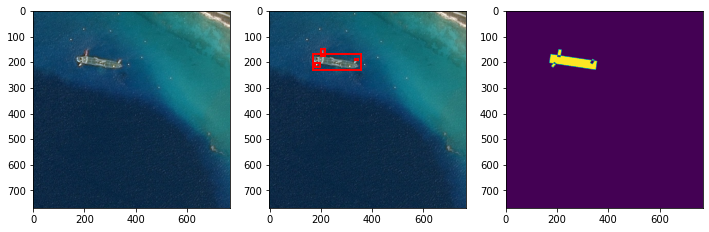

In [55]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

ax1.imshow(img1[:, :, [2, 1, 0]])
ax2.imshow(img1[:, :, [2, 1, 0]])
for bbox in bboxes:
    print(bbox)
    rect = patches.Rectangle(
        (bbox[0], bbox[1]), 
        bbox[2] - bbox[0], 
        bbox[3] - bbox[1],
        linewidth = 2,
        edgecolor="red",
        facecolor=None,
        fill=False
    )
    ax2.add_patch(rect)

ax3.imshow(all_masks)

In [56]:
def apply_single_mask(
    image: np.array, mask: np.array, color: tuple, alpha: float = 0.3
) -> np.array:
    """A method to generate visualization of masks
    Args:
        image (np.array): Input image
        mask (np.array): Mask
        color (tuple): Color of mask (R, G, B)
        alpha (float, optional): Non-transparency of mask. Defaults to 0.6.
    Returns:
        np.array: Image with mask visualization
    """
    out = image.copy()
    for c in range(3):
        out[:, :, c] = np.where(
            mask != 0, image[:, :, c] * (1 - alpha) + alpha * color[c], image[:, :, c]
        )
    return out

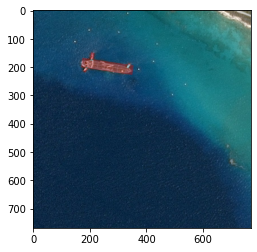

In [57]:
alpha_blend = apply_single_mask(img1[:, :, [2, 1, 0]], all_masks, [255, 0, 0])
plt.imshow(alpha_blend)